# Introduction to Time Domain Astronomy
This is a branch of astronomy which deals with, well objects that change with time. Changes can be for various reasons, intrinsic to the object as well as due to other factors such as motion. A very good schematic that groups together several types of transients is given below. 

In today's tutorial, we will discuss the following transients:
1. **Cepheid Variables**, in particular $\delta$ Cepheids
2. **Planetary Transits** (an Exoplanet detected by Kepler K2)
3. A type of transient which is all together not very well understood, but is extremely relevant in the current research in Transient Astronomy, **Gamma Ray Bursts**

All of the tasks, from data retrieval to processing will be done by ... you!!<br>
The outline for how to proceed is given below. So you can think of this as an extended Assignment. 

![Transient Schematic](Updated-version-of-the-variability-tree-presented-in-Eyer-Mowlavi-2008-separated.png)

(Adapted from : Laurent Eyer and Nami Mowlavi 2008 J. Phys.: Conf. Ser. 118 012010)

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt

# Lomb-Scargle Periodorgram:
from astropy.timeseries import LombScargle, BoxLeastSquares

# FITS load
from astropy.io import fits

## Cepheid Variables
If you see the schematic, you will notice that Cepheid Variables come under the category of pulsating stars. These are stars, which due to some instability inherent in them, pulsate (i.e. expand and contract) with some period. As it turns out, the period of the Cepheid and the luminosity (i.e. the absolute magnitude) of the Cepheid are related. Theoretically, there are several models that are used to explain this, but we will focus today on how Cepheids were discovered: observations!!

In 1908, [Henrietta Swan Leavitt](https://en.wikipedia.org/wiki/Henrietta_Swan_Leavitt) discovered the peculiar property of certain stars in the Small Magellanic Cloud, where their magnitude (brightness) was linearly related the logarithm of the period of their variability.

The Small Magellanic Cloud is a dwarf galaxy satellite of the Milky Way, and distances to any star in it can be assumed to be almost constant. So the magnitudes translated directly into absolute magnitudes with some offset dependent on the distance to the SMC. 

Cepheids are today one of the most commonly used [Standard Candles](https://en.wikipedia.org/wiki/Cosmic_distance_ladder#Standard_candles), although several more classes of Cepheids have been observed.

In today's tutorial, we will take data from a survey called OGLE (Optical Gravitational Lensing Experiment), which has observed several thousands of variable stars. A screenshot of a data query page (go [here](http://ogledb.astrouw.edu.pl/~ogle/OCVS/ceph_query.php)) is found below:

![Data Access Screenshot](./OGLE_screenshot.png)

Here, the first column (_show_) allows you to show or hide certain columns in your query. Select the ones as seen in the screenshot. _Use_ column allows you to filter out the cepheids based on the _value/range_ selected in the next column. For now, we will use SMC Cepheids in the I filter (you can use LMC as well, it should give you similar results). After selecting press _Submit Query_. 

A few things to note: as with all oscillations, there are stars that pulsate in their fundamental frequency (F), as well as those that oscillate in higher overtones (1O, 2O), as well as mixed (F/1O, ...). Since we are, for now, concerned with the fundamental period, select only F in the Value/Range column. 

The HTML page you come to will now, show a list of Cepheids detected along with their properties. We are only concerned with the ID, the Mode (which should be F), I band magnitude and Period (as well as error in Period). 

First we will see how the light curve of a Cepheid looks and how to get the period from it. 

Select any of the Cepheids from the query page. You will see a 'phase-folded' light curve there (we will see what this is later). 
In the "View photometry file" section at the end, click on the I-band link. It will lead you to a plain text file, which you can save ('Ctrl+S') as a .dat file. The columns in the file are Time (in days), Magnitude (I-band) and Error in Magnitude (also I band). 

In [2]:
# Load the data file below

# I will use here the star OGLE-SMC-CEP-0001 here (This is not a fundamental oscillator!!!)
time, I_mag, e_I_mag = np.genfromtxt("OGLE-SMC-CEP-0001.dat", unpack=True)

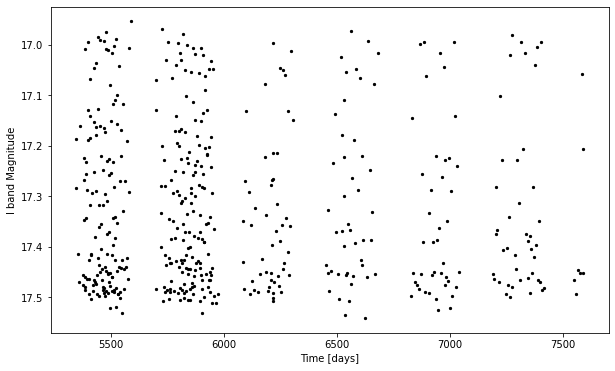

In [3]:
# Make a scatter plot of Time vs Magnitude
plt.figure(figsize=(10,6))
plt.scatter(time, I_mag, s=5, color='k')
plt.xlabel("Time [days]")
plt.ylabel("I band Magnitude")
plt.gca().invert_yaxis()

Well, that was anticlimactic. What happened to the clean light curve we saw in the HTML page?

The answer is that we cannot continuously observe the star for the full length of the period (unless you are looking at Kepler data). So we can only sample the star's light-curve at different oscillations. 

However, all is not lost. This is where phase folding comes into picture. We assume a period, and find the phase at which we observed each magnitude and scatter plot the phase vs magnitude instead.

If you don't understand yet, have a look at the function below

In [4]:
assumed_period = 1.1283
# Below, replace time_data with the name you have used.
phase = np.remainder(time, assumed_period)/assumed_period 
# The division is just to normalise to the range of (0,1). Comment it out if you want a range of (0, period)

After you have done this, try making a scatter plot of Phase vs. Magnitude. If you get the period just about right, then you will have a smoother light curve. If you want to cheat a bit, use the Period given in the data page on that Cepheid ;)

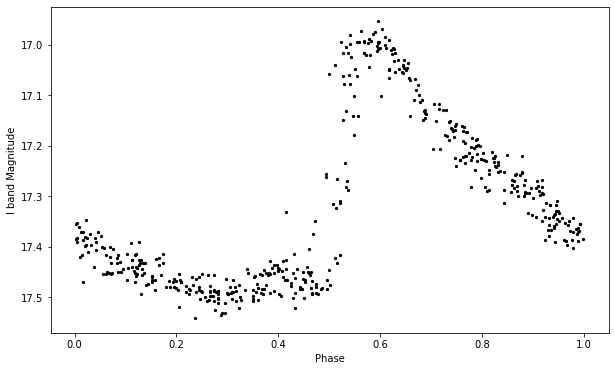

In [5]:
# Make a scatter plot of Time vs Magnitude
plt.figure(figsize=(10,6))
plt.scatter(phase, I_mag, s=5, color='k')
plt.xlabel("Phase")
plt.ylabel("I band Magnitude")
plt.gca().invert_yaxis()

Of course, we can't just go about changing Period and finding the best looking light-curve, atleast not for thousands of stars. So we need to find another way to deal with things. In an normal light curve (where the times at which data is collected are equally spaced), if we want to find the frequencies that exist in the time series, the best way to do so is by using the Fourier [Power Spectrum](https://en.wikipedia.org/wiki/Spectral_density). 

However, our data is going to have unequal spacing (we can't observe during the day). So unfortunately, we can't rely only on the FFT (Fast Fourier Transform). 

There is however, a way in which we can approximate the Power Spectrum, and this is called a Periodogram. One such Periodogram is the Lomb-Scarge Periodogram. If you are interested in more details, check out this paper: [Understanding the Lomb-Scargle Periodogram](https://arxiv.org/abs/1703.09824)

If however, you haven't understood much and skipped directly here, this is all you need to know to use these tools. It gives you the 'power' of each frequency in a given time-series. The frequency with the most power then is our best bet for being the fundamental frequency of the actual time-series. 

In [6]:
frequency, power = LombScargle(time, I_mag, e_I_mag).autopower(minimum_frequency=0.0001, maximum_frequency=10, samples_per_peak=20)
# This is it, for the most part. You can also add the error in mag_data as an additional argument.

The autopower function selects out a frequency range which it deems ideal for containing the possible frequency. However, you can input your own frequency range using the arguments `minimum_frequency` and `maximum_frequency`. 

To see your power spectrum, make a plot between frequency and power. 

Text(0, 0.5, 'Power')

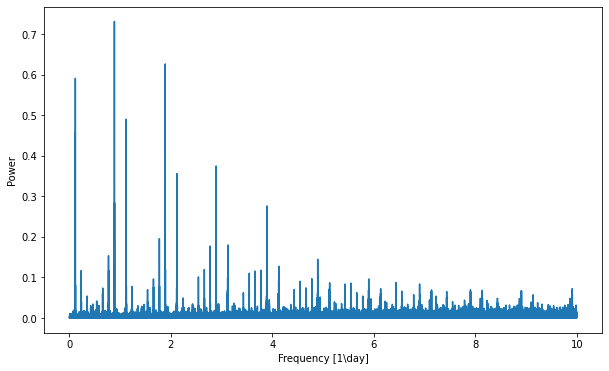

In [7]:
plt.figure(figsize=(10,6))
plt.plot(frequency, power)
plt.xlabel('Frequency [1\day]')
plt.ylabel('Power')

Peaks occuring in integer multiples are because of the higher harmonics. However we see two sets of these multiples, suggesting that there is some other source of periodicity in the data.

The `samples_per_peak` argument allows for more resolution in sampling the peak, and hence the period

You should see a high peak in the power spectrum. Your next task is to take find the frequency corresponding to the peak (`np.argmax` might be useful here). Then find the period from the frequency, and use it to plot a phase-folded light curve as earlier. 

Text(0.5, 1.0, 'Phase Folded Light Curve with Errors')

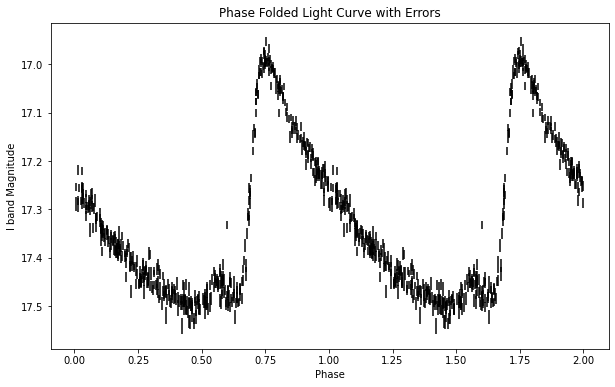

In [8]:
# Find the Period from the Power Spectrum
ind_max_power = power.argmax()
period = 1/frequency[ind_max_power]

# Phase folded light curve
phase = np.remainder(time, period)/period 

plt.figure(figsize=(10,6))
# This is a small trick to see a fully continuous phase folded light curve. 
# We just plot the same graph again to the side
plt.errorbar(np.append(phase, phase+1), np.append(I_mag, I_mag), np.append(e_I_mag, e_I_mag), color='k', ls='')
plt.xlabel("Phase")
plt.ylabel("I band Magnitude")
plt.gca().invert_yaxis()
plt.title("Phase Folded Light Curve with Errors")

In [9]:
print(f"Period Found Using LombScargle: {period:5f} days")

Period Found Using LombScargle: 1.128264 days


This concludes, for now, our investigation on how to find the Period of a Cepheid (or in-fact any pulsating variable), using the Lomb-Scargle Periodogram. And finally, just to see, let us plot the Period-Luminosity Relation for our selected bunch of Cepheids. 

In the HTML page with the list of Cepheids, there is an option to _Download Data_. Select "Star Table" (gives only the columns we asked for), and save the data file. 

In [10]:
# Load Star Table Data file
data = np.loadtxt("SMC_Cepheids.txt", dtype='str')

In [11]:
# This takes care of stars observed only in V band (so their magnitude in I was set to -99.99 to filter out easily)
ind = np.where(data[:,4] != "-99.99")

In [12]:
I = data[ind,4].astype('f')
P = data[ind,5].astype('f')

Text(0.5, 1.0, 'Period Luminosity Relation for SMC Classical Cepheids')

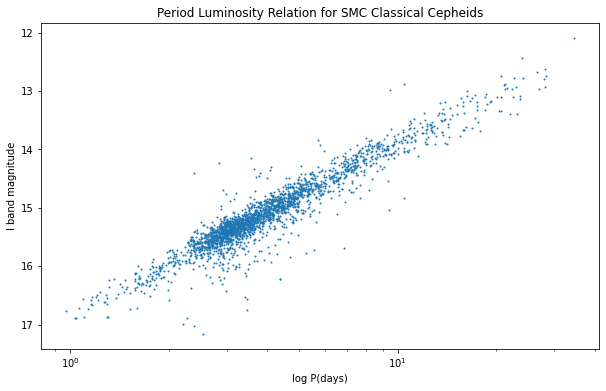

In [13]:
# Plot I band magnitude (Y-axis) vs logarithm of the Period (X-axis) and verify a linear relation

plt.figure(figsize=(10,6))
plt.scatter(P, I, s=1)
plt.xscale('log')
plt.gca().invert_yaxis()
plt.xlabel('log P(days)')
plt.ylabel('I band magnitude')
plt.title('Period Luminosity Relation for SMC Classical Cepheids')

## Exoplanets
One of the main methods of detecting Exoplanets is to observe the host star's brightness and notice dips when the planet passes in front of the star. These are called Transits and the highly sensitive Kepler mission discovered thousands of planets using this method.

To download data, go to this [site](https://archive.stsci.edu/pub/kepler/lightcurves/0106/010666592/), and download the file `kplr010666592-2009131110544_slc.fits` (this should be the second file).

General instructions for downloading any light curve given a Kepler ID can be found [here](https://archive.stsci.edu/kepler/download_options.html)

The light curve is a FITS data file. We have seen these before (in the tutorial on Astropy Quantities). To get the data directly without worrying about the HDUs, use the `fits.getdata` function. 

We will be using the 'Time' and 'SAP_FLUX' columns of the fits file. (SAP is Simple Aperture Photometry). Make a scatter-plot and see how the transits look. 

In [14]:
data = fits.getdata('kplr010666592-2009131110544_slc.fits')
time = data['time']
flux = data['sap_flux']

Text(0, 0.5, 'Flux [e/s]')

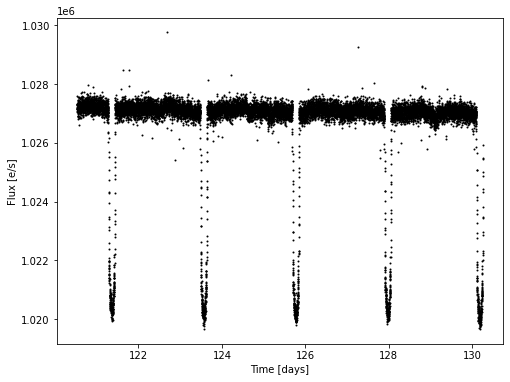

In [15]:
# Scatter plot of SAP_Flux vs Time
plt.figure(figsize=(8,6))
plt.scatter(time, flux, s=1, color='k')
plt.xlabel('Time [days]')
plt.ylabel('Flux [e/s]')

To find the period quantitatively, using a Lomb-Scargle Periodogram seems slightly inappropriate; this light curve doesn't resemble a sinusoid in any way. Instead we will use another Periodogram in `astropy.timeseries` called `BoxLeastSquares`. The usage is similar to `LombScargle`; so it is left to you to find the period of the transits, and hence the orbital period of the exoplanet. 

To know more about `BoxLeastSqaures`, consult the AstroPy Documentation for the mathematics behind it [here](https://docs.astropy.org/en/stable/timeseries/bls.html#mathematical-background)

In [16]:
# There are some NaN values in the flux. So, we will find their indices to filter them out
sel_nan = np.isnan(flux)

In [17]:
# Implement BoxLeastSquares
model = BoxLeastSquares(time[~sel_nan], flux[~sel_nan]) # ~ is the unary Not operator
periodogram = model.autopower(0.2)

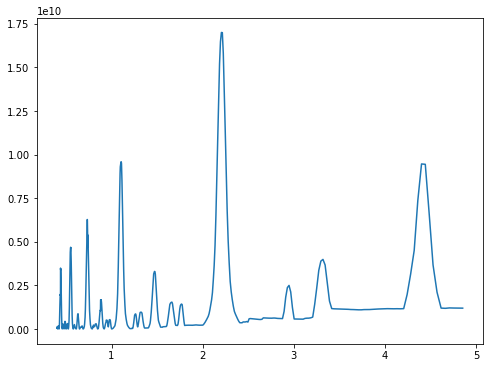

In [18]:
# Plot the power Spectrum
periods = periodogram.period
power = periodogram.power

plt.figure(figsize=(8,6))
plt.plot(periods, power)


Text(0, 0.5, 'Flux [e/s]')

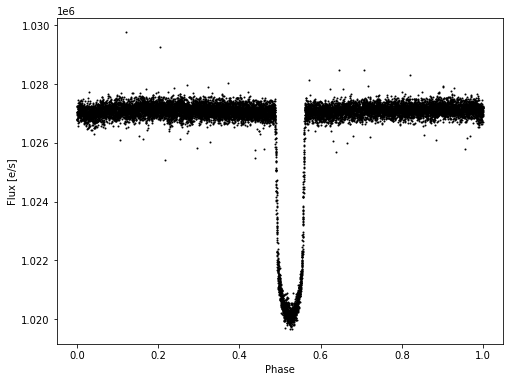

In [19]:
best_period = periods[np.argmax(power)]
# Plot the Phase-Folded Light curve for the Exoplant Transit using the Period found.

# The added phase to the time is just to center the transit.
phase = np.remainder(time+best_period/2, best_period)/best_period 

plt.figure(figsize=(8,6))
plt.scatter(phase, flux, s=1, color='k')
plt.xlabel("Phase")
plt.ylabel("Flux [e/s]")


Hopefully, this should have given you some insight into how the periods of all those Cepheids and Exoplanets are found. Now, we will look into something a bit different, Gamma Ray Bursts

## Gamma Ray Bursts
GRBs are extreme explosions seen in high energies (X-rays and Gamma rays). These originate from far away galaxies, so by the time they reach here, they are, thankfully a miniscule fraction of their original intensity. However, this is still enough to show up as huge spikes in time-series data from X-ray satellites. 

Today we will use data from an Indian Space Telescope called AstroSat; specifically an instrument on it called CZTI. A list of GRBs found using CZTI is maintained at the CZTI GRB Monitor [Page](http://astrosat.iucaa.in/czti/?q=grb), and the data used here has been taken from the dataset used in the GROWTH Winter School 2018. 

Download the Data from [this](https://drive.google.com/open?id=1MZrrcWzJbcEGbvYlHYD3gmhn9OI0TAhU) Google Drive folder (it is around 76 MB). We will not be doing any analysis beyond viewing the light curve.

In [20]:
hdu = fits.open('AS1A02_005T01_9000000948_06884cztM0_level2_common_clean.evt')

The HDUs numbered 1,2,3 and 4 are data for 4 independent quadrants of CZTI. Fo today, we will use all of these quadrants together and see the total light curve in X-ray as seen using CZTI. 

Each row of the file has details about each photon seen by CZTI (that's right, _every_ photon detected). We will only use the time at which the photons were detected here. In a Gamma Ray Burst, we expect to see a large number of photons coming in a short period of time. To see this, we will bin the time data to get the light curve

In [21]:
times = np.concatenate((hdu[1].data['Time'], hdu[2].data['Time'],
                        hdu[3].data['Time'], hdu[4].data['Time']))

Text(0, 0.5, '$counts\\ s^{-1}$')

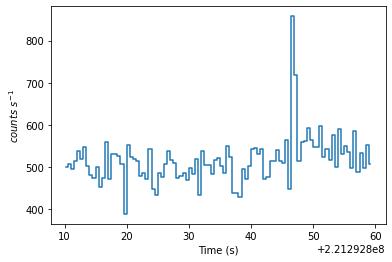

In [22]:
# Define bins. You can change this up and see how the light curve changes
binsize = 0.5
# # Use this option to see the entire light curve for an orbit of the Satellite. 
# # The detectors are switched off above certain regions of the Earth, known as the South-Atlantic Anomaly
# tbins = np.arange(times.min(), times.max(), binsize)

# Use this data to see only some data containing the GRB. 
# These times are essentially number of seconds since Midnight, Jan 1, 2010.
tbins = np.arange(221292810.0, 221292860.0, binsize)

# Bin the time data
counts, bins = np.histogram(times, bins=tbins)
bins = (bins[1:] + bins[:-1])/2

# Plot the light curve
plt.plot(bins, counts/binsize, drawstyle='steps-mid')
plt.xlabel('Time (s)')
plt.ylabel('$counts\ s^{-1}$')

This is how a GRB looks in an X-ray time series. You will notice that the number of photons detected in X-rays is significantly lower than in the Optical wavelengths. Can you think of a way to detect these?

One interesting thing about GRBs is that sometimes they have optical counterparts, called the GRB afterglow which fades away very quickly. To conclude this tutorial, we will look at a GRB afterglow observed by the GROWTH-India telescope, reported in this [GCN](https://gcn.gsfc.nasa.gov/gcn/gcn3/25560.gcn3). GCNs are notices circulated whenever astronomers find a transient source. You can see the most recent ones [here](https://gcn.gsfc.nasa.gov/gcn3_archive.html). 

The GCN has data in the 'g' filter. The columns are Julian Days (essentially, time of observation), dt_minutes (time after the GRB was detected in X-rays, in minutes), and magnitude and error in magnitude. 

Your final task for today is to plot the light curve from this GRB afterglow and verify the power law given in the GCN.

In [23]:
# The Data is copied to a text file
mjd, time, mag, e_mag = np.genfromtxt('GCN25560.txt', unpack=True, skip_header=1)

In [24]:
from scipy.optimize import curve_fit

In [25]:
def line(x, m, c):
    return m*x+c

The power law decline is said to be of slope 1.6. 

This means that in a plot of log(Flux) vs log(Time), the slope would be -1.6. 
magnitude is equal to -2.5 log(Flux) (up to an additive constant). So we can effectively plot mag/(-2.5) vs log(time). 

In [26]:
popt, perr = curve_fit(line, np.log10(time), mag/-2.5)

Text(0.5, 1.0, 'Power law slope is -1.62')

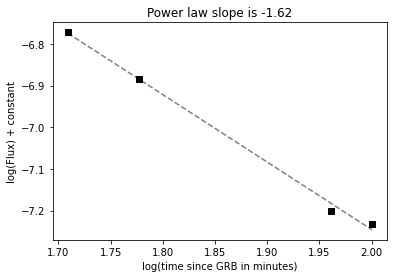

In [27]:
plt.scatter(np.log10(time), mag/-2.5, color='k', marker='s')
plt.plot(np.log10(time), line(np.log10(time), *popt), color='k', ls='--', alpha=0.5)
plt.xlabel('log(time since GRB in minutes)')
plt.ylabel('log(Flux) + constant')
plt.title(f'Power law slope is {popt[0]:2.2f}')